In [1]:
!pip install matplotlib
import matplotlib.pyplot as plt

### Exercise 1: Parallel Monte Carlo for PI
Implement a parallel version of Monte Carlo using the function above:
Ensure your program works correctly if N is not an exact multiple of the number of processes 

In [2]:
#exercice 1
%%file exercice1.py

import random
from mpi4py import MPI

def compute_points(INTERVAL):
    circle_points = 0
    for _ in range(INTERVAL**2):
        rand_x = random.uniform(-1, 1)
        rand_y = random.uniform(-1, 1)
        origin_dist = rand_x**2 + rand_y**2
        if origin_dist <= 1:
            circle_points += 1
    return circle_points

def monte_carlo_parallel(N):
    COMM = MPI.COMM_WORLD
    SIZE = COMM.Get_size ()
    RANK = COMM.Get_rank()
    sendbuf = None
    if RANK == 0:
        sendbuf= [N//SIZE for i in range(SIZE)  ]
        sendbuf[SIZE-1] = sendbuf[SIZE-1]  + N%SIZE 
        summ = sum([i**2 for i in sendbuf])
    recvbuf = COMM.scatter(sendbuf , root=0)

    nem_point=compute_points(recvbuf)      
    sum_reduce = COMM.reduce( nem_point , op=MPI.SUM , root = 0)
    if RANK == 0:
        pi= 4*sum_reduce/summ
        return pi
print(monte_carlo_parallel(10000))   

UsageError: Line magic function `%%file` not found.


In [3]:
!mpirun -n 4 python3 exercice1.py


3.14187872
None
None
None


### Exercise 2 Parallel Stochastic Gradient Descent for Linear Regression

Implement a parallel version of Stochastic Gradient Descent (SGD) for linear regression using MPI. The goal is to distribute the dataset across multiple MPI processes, perform local updates (gradient descent steps) on each process, and periodically synchronize the model parameters across all processes.
Ensure your program works correctly if N is not an exact multiple of the number of processes P

Dataset: Use a synthetic dataset for simplicity. You can generate a dataset with a single feature and a linear relationship with the target variable. For example, you can model the relationship y = 2x + noise, where noise is some Gaussian noise

In [4]:
#exercice2
%%file ass1_exo2.py

import random
from mpi4py import MPI
import numpy as np
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size ()
RANK = COMM.Get_rank()
N = 1000
x = [np.random.uniform(0,1) for i in range(N)]
y = [2*x + np.random.normal(0, 1) for x in x]
## fonction qui calcul le gradian d'une fonction J(w,b)
def compute_gradiant(x,y,w,b):
    N=len(x)
    dJ_w = (2/N)*(sum([ (w*x[i] +b -y[i])*x[i] for i in range(N)]))
    dJ_b = (2/N)*(sum([ w*x[i] +b -y[i] for i in range(N)]))
    return dJ_w, dJ_b

## calcule parallél
### fonction return w et b optimal (gradiant a pas fixe)
def  gradient_stochastique(w_0, b_0,x,y):
    h = 0.01
    eps = 0.0001
    w = w_0
    b = b_0
    itr_max= 100
    while np.linalg.norm(compute_gradiant(x,y,w_0,b_0))>eps:
        w = w - h*compute_gradiant(x,y,w,b)[0]
        b = b - h*compute_gradiant(x, y,w,b)[1]
        if itr_max >= 100:
            break
    return w ,b 
##fonction return w et b optimal utilisant le calcul parallel 
def calcul_parallel(x, y, w, b) :
    COMM = MPI.COMM_WORLD
    SIZE = COMM.Get_size ()
    RANK = COMM.Get_rank()
    L = None
    sendbuf_x= []
    sendbuf_y= []
    if RANK == 0:
        #sendbuf_w= []
        #sendbuf_b= []
        L = [ N//SIZE for i in range(SIZE)  ]
        L[SIZE-1] = L[SIZE-1]  + N%SIZE 
        for ind,i in enumerate(L):
            s = sum(L[:ind])
            print(s, s+i)
            x_local = [x[j] for j in range(s, i+s, 1)]
            y_local = [y[j] for j in range(s, i+s, 1)]

            sendbuf_x.append(x_local)
            sendbuf_y.append(y_local)
            #sendbuf_w.append(w_local)
            #sendbuf_b.append(b_local)    
                
    recvbuf_x = COMM.scatter(sendbuf_x , root=0)
    recvbuf_y = COMM.scatter(sendbuf_y , root=0)
    #recvbuf_w = COMM.scatter(sendbuf_w , root=0)
    #recvbuf_b = COMM.scatter(sendbuf_b , root=0)

    # iteration
    h = 0.01
    eps = 0.0001
    w = 1
    b = 0
    itr_max= 1000
    i=0
    while True:
        grad_local = compute_gradiant(recvbuf_x,recvbuf_y,w,b)
        COMM.Barrier()
        sum_reduce_dw = COMM.allreduce(grad_local[0], op=MPI.SUM)
        sum_reduce_db = COMM.allreduce(grad_local[1], op=MPI.SUM)
        w = w - h*sum_reduce_dw
        b = b - h*sum_reduce_db
        i += 1

        if np.linalg.norm([sum_reduce_dw, sum_reduce_db])<eps or i >= itr_max:
            break
    
    if RANK == 0:
        print(f"iter: {i}")
        return [w ,b]

    """
    grad_local_w, grad_local_b = compute_gradiant(recvbuf_x,recvbuf_y,w,b)
       
      
    sum_reduce_dw = COMM.allreduce( grad_local_w, op=MPI.SUM , root = 0)
    sum_reduce_db = COMM.allreduce(  grad_local_b, op=MPI.SUM , root = 0)
   
    if RANK == 0:
        return [sum_reduce_dw, sum_reduce_db]"""
## appell la fonction calcul parallel
RESULT = calcul_parallel(x, y, 1, 0)
print(f"[w_optimal,b_optimal]={RESULT}") 

"""
def  gradient_stochastique_parallel(x,y,w_0,b_0):
    h = 0.01
    eps = 0.0001
    w = w_0
    b = b_0
    itr_max= 100
    i=0
    while True:
        gradient = calcul_parallel(x,y,w,b)
        print("gradient: ")
        print(gradient)
        w = w - h*gradient[0]
        b = b - h*gradient[1]
        i += 1
        if np.linalg.norm(gradient)>eps or i >= itr_max:
            break
    return w ,b 

if RANK ==0:
    resutat = gradient_stochastique_parallel(x,y, 1,0)
    print(resutat)
"""

UsageError: Line magic function `%%file` not found.


In [5]:
!mpirun -n 2 python3 ass1_exo2.py

0 500
500 1000
[w_optimal,b_optimal]=None
iter: 1000
[w_optimal,b_optimal]=[2.1533359463129753, -0.057237026808242907]


In [6]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install numba


Note: you may need to restart the kernel to use updated packages.


### Exercise 3: Matrix vector product
Exercise 3: Matrix vector product

1. Use the code above to implement the MPI version of matrix-vector multiplication.
2. Ensure your program works correctly if N is not an exact multiple of the number of processes P
3. Process 0 compares the result with the dot product.

4. Plot the scalability of your implementation

In [14]:
#exer3
%%file ass1_exo3.py
#########This program compute parallel csc matrix vector multiplication using mpi########

import numpy as np
from scipy.sparse import lil_matrix
from numpy.random import rand, seed
from numba import njit
from mpi4py import MPI

COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()

seed(42)
def matrixVectorMult(A, b, x):
    
    row, col = A.shape
    for i in range(row):
        a = A[i]
        for j in range(col):
            x[i] += a[j] * b[j]

    return 0
########################initialize matrix A and vector b ######################
#matrix sizes
SIZE = 1000

if RANK == 0:
    L = [ SIZE//nbOfproc for i in range(nbOfproc)  ]
    L[nbOfproc-1] = L[nbOfproc-1]  + SIZE%nbOfproc 
    YY = [ np.zeros((i,SIZE ), dtype=np.float64) for i in L]
    Local_size = [[i, SIZE] for i in L]

    # counts = block of each proc
    counts = [i*SIZE for i in L]
    
    ##initialize matrix A and vector b
    # A = np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]], dtype=np.float64)
    # b = np.array([1, 1, 1])
    A = lil_matrix((SIZE, SIZE))
    A[0, :100] = rand(100)
    A[1, 100:200] = A[0, :100]
    A.setdiag(rand(SIZE))
    A = A.toarray()
    b = rand(SIZE)
else :
    A = None
    b = None
    YY = None
    counts = None
#########Send b to all procs and scatter A (each proc has its own local matrix#####
#LocalMatrix = 
matrice_local = COMM . scatter ( YY , root=0 )  
# Scatter the matrix A
b_local = COMM . bcast (b , root=0 ) 
COMM.Scatterv( [A , counts , MPI.DOUBLE],  recvbuf=matrice_local ,root =0)

#####################Compute A*b locally#######################################
LocalX=np.zeros(matrice_local.shape[0])
start = MPI.Wtime()
matrixVectorMult(matrice_local, b_local, LocalX)

stop = MPI.Wtime()
dt= (stop - start)*1000
dt_max= COMM.allreduce(dt, op=MPI.MAX)
if RANK == 0:
    print("CPU time of parallel multiplication is ", dt_max)
##################Gather te results ###########################################
recvbuf = COMM . gather (LocalX , root=0 )  
if RANK ==0:
    X = np.concatenate(recvbuf, axis=0) 
else :
    X=None 
##################Print the results ###########################################
if RANK == 0 :
    X_ = A.dot(b)
    print("The result of A*b using dot is :", np.max(X_ - X))
    #print("The result of A*b using dot is :", X_)
    #print("The result of A*b using parallel version is :", X)

UsageError: Line magic function `%%file` not found.


In [15]:
!mpirun -n 2 python3 ass1_exo3.py

CPU time of parallel multiplication is  131.521986
The result of A*b using dot is : 1.4210854715202004e-14


##### Plot the scalability of your implementation.

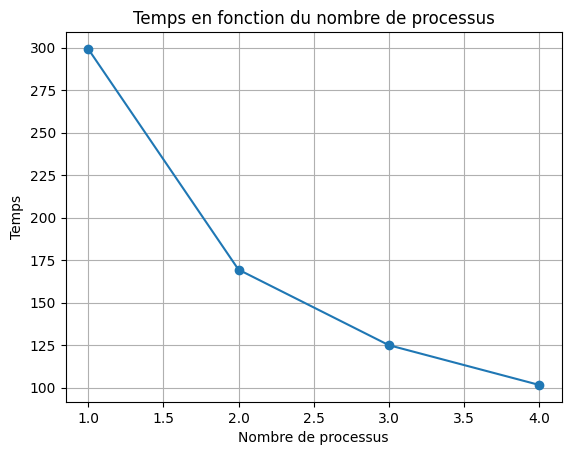

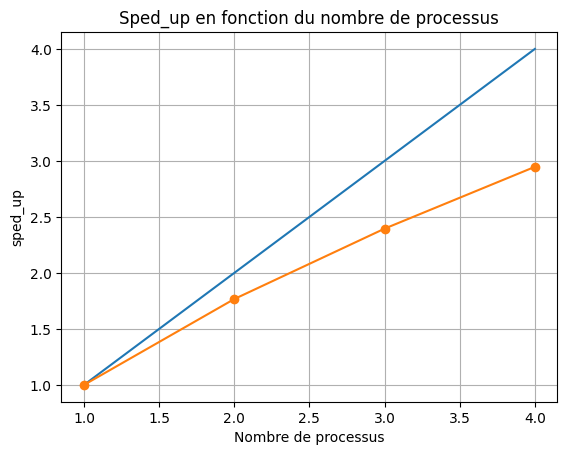

In [10]:
temp= [299.204396,169.349427,124.913028,101.51989999999999]
sped_up=[temp[0]/i for i in temp]
NP= [1,2,3,4]
# Tracé le graph de temps en fonction de number de pross
plt.plot(NP, temp, marker='o', linestyle='-')
plt.xlabel('Nombre de processus')
plt.ylabel('Temps')
plt.title('Temps en fonction du nombre de processus')
plt.grid(True)
plt.show()
# le graphe de sped_up en fonction de nombre de pross
plt.plot(NP, NP, linestyle='-')
plt.plot(NP, sped_up, marker='o', linestyle='-')
plt.xlabel('Nombre de processus')
plt.ylabel('sped_up')
plt.title('Sped_up en fonction du nombre de processus')
plt.grid(True)
plt.show()


In [13]:
%%file exam2.py

from mpi4py import MPI
import numpy as np

COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

if RANK == 0:
    # initialiser la taille de la matrice
    n = 8

    # déclaration de la matrice
    matrice = np.zeros((n, n))

    # Initialiser la diagonale de la matrice de 1 à n
    for i in range(n):
        matrice[i, i] = i + 1

    # Distribuer la matrice en p parties avec p étant le nombre de processus
    L = [n // SIZE] * SIZE
    for i in range(n % SIZE):
        L[i] += 1

    Local_size = [[i, i] for i in L]
    
    # Diviser la matrice en parties
    data = np.split(matrice, np.cumsum(L)[:-1], axis=0)

else:
    data = None

# Envoyer les parties de la matrice aux autres processus
local_matrice = COMM.scatter(data, root=0)

# Calculer la trace locale
local_trace = np.trace(local_matrice)

# Rassembler les résultats dans le processus 0
all_traces = COMM.gather(local_trace, root=0)

# récupération de la trace totale
if RANK == 0:
    total_trace = sum(all_traces)
    print("la Trace de la matrice est :", total_trace)


Overwriting exam2.py


In [16]:
!mpirun -n 4 python3 exam2.py

la Trace de la matrice est : 3.0


In [31]:
%%file exam3.py
from mpi4py import MPI
import numpy as np

COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

def distribute_data(matrice, size):
    n = matrice.shape[0]
    part_size = n // size
    remainder = n % size

    data = []
    start_row = 0
    for i in range(size):
        end_row = start_row + part_size + (1 if i < remainder else 0)
        data.append(matrice[start_row:end_row, :])
        start_row = end_row

    return data

if RANK == 0:
    # initialiser la taille de la matrice
    n = 8

    # déclaration de la matrice
    matrice = np.zeros((n, n))

    # Initialiser la diagonale de la matrice de 1 à n
    for i in range(n):
        matrice[i, i] = i + 1

    # Distribuer la matrice en parties 
    data = distribute_data(matrice, SIZE)
else:
    data = None

# Envoyer les parties de la matrice aux autres processus (les sous matrice)
local_matrice = COMM.scatter(data, root=0)

# Calculer la somme locale des éléments
local_sum = np.sum(local_matrice)

# Rassembler les résultats dans le processus 0
all_sums = COMM.gather(local_sum, root=0)

# Calculer la trace globale
if RANK == 0:
    global_sum = sum(all_sums)
    print("La trace de la matrice est  :", global_sum)




Overwriting exam3.py


In [32]:
!mpirun -n 2 python3 exam3.py

La trace de la matrice est  : 36.0
